# Projekt I - delta i gamma hedging

W projekcie zakładamy, że dziś jest 1 stycznia 2017.

Zasymuluj przyszłe trajektorie WIG20 od dziś do końca roku dobierając odpowiednio zmienność i dryft na podstawie danych historycznych. Posłuż się dynamiką geometrycznego ruchu Browna.

In [ ]:
import pandas as pd
import math
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.mlab as mlab


# Ładujemy dane historyczne.
wig_20_daily_url = 'https://raw.githubusercontent.com/wfica/inz_fin_1/main/wig20_d.csv'
wig_20_daily_all = pd.read_csv(wig_20_daily_url)
wig_20_daily_all['Date'] = pd.to_datetime(wig_20_daily_all['Date'])

# Liczymy historyczne zwroty względne.
wig_20_daily_all['Returns'] = wig_20_daily_all['Close'].pct_change()

# Dane, które używamy do predykcji (td = training data).
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2017-01-01')
wig_20_daily_td = wig_20_daily_all.loc[(wig_20_daily_all['Date'] >= start_date) & (wig_20_daily_all['Date'] < end_date)]

# Dni handlowe 
trading_days = wig_20_daily_td.shape[0]
dt = 1./ trading_days

# Średnia i odchylenie standardowe
mean = wig_20_daily_td['Returns'].mean()
std = wig_20_daily_td['Returns'].std()

# Normujemy parametry
mu = mean * trading_days
sigma = std * math.sqrt(trading_days)
print(std)
mu, sigma

0.01197013659990396


(0.06458126168654821, 0.18964262897700623)

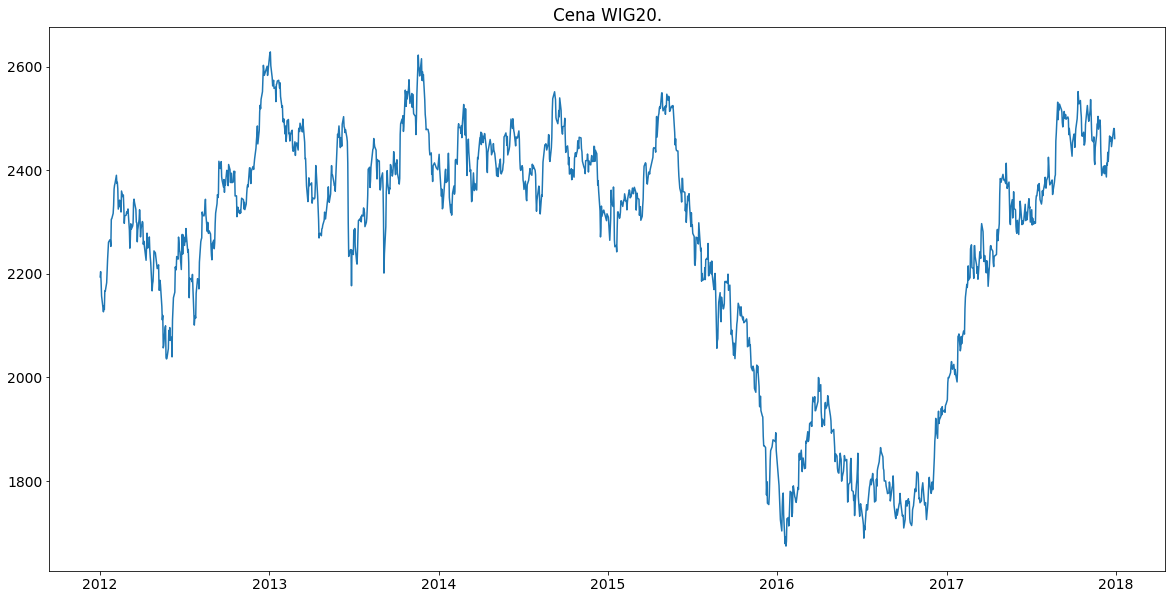

In [ ]:
plot_start = pd.to_datetime('2012-01-01')
plot_end = pd.to_datetime('2017-12-31')
wig_20_plot = wig_20_daily_all.loc[(wig_20_daily_all['Date'] >= plot_start) & (wig_20_daily_all['Date'] < plot_end)]

plt.figure(figsize=(20,10))
plt.plot(wig_20_plot['Date'],wig_20_plot['Close']  )
plt.title('Cena WIG20.')
plt.show()
# plt.savefig('wig20_cena.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('wig20_cena.png')

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  2.,  5.,  4.,  1.,  6.,  5., 16.,
        13., 21., 27., 21., 35., 22., 16., 15., 14.,  7.,  5.,  3.,  4.,
         2.,  2.,  0.,  2.]),
 array([-0.04533611, -0.04262867, -0.03992123, -0.03721379, -0.03450635,
        -0.03179892, -0.02909148, -0.02638404, -0.0236766 , -0.02096916,
        -0.01826172, -0.01555428, -0.01284684, -0.0101394 , -0.00743196,
        -0.00472453, -0.00201709,  0.00069035,  0.00339779,  0.00610523,
         0.00881267,  0.01152011,  0.01422755,  0.01693499,  0.01964242,
         0.02234986,  0.0250573 ,  0.02776474,  0.03047218,  0.03317962,
         0.03588706]),
 <a list of 30 Patch objects>)

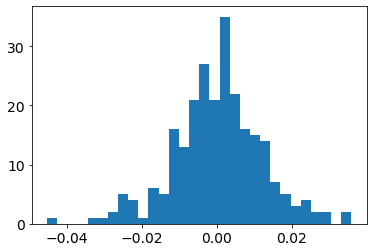

In [ ]:
plt.hist(wig_20_daily_td['Returns'].values.flatten(), bins=30)
# wig_20_daily_td['Returns'].values.flatten().shape

In [ ]:
wig_20_daily_2017 = wig_20_daily_all.loc[(wig_20_daily_all['Date'] >= pd.to_datetime('2017-01-01')) & (wig_20_daily_all['Date'] < pd.to_datetime('2018-01-01'))]
trading_days_2017 = wig_20_daily_2017.shape[0]
# Średnia i odchylenie standardowe
mu_2017 = wig_20_daily_2017['Returns'].mean() * trading_days_2017
sigma_2017 = wig_20_daily_2017['Returns'].std() * math.sqrt(trading_days_2017)
mu_2017, sigma_2017

(0.24523907826307165, 0.15050088407391107)

Przyjmujemy że cena indeksu zmienia się według wzoru:

$ dS = \mu S dt  + \sigma S dX$

tj.

$ S_{i+1} = S_{i} (1 + \mu dt + \sigma \phi dt^{\frac{1}{2}}) $

gdzie 

$\phi$ jest losową liczbą wybraną ze standardowego rozkładu normalnego.

In [ ]:
plt.rcParams.update({'font.size': 14})

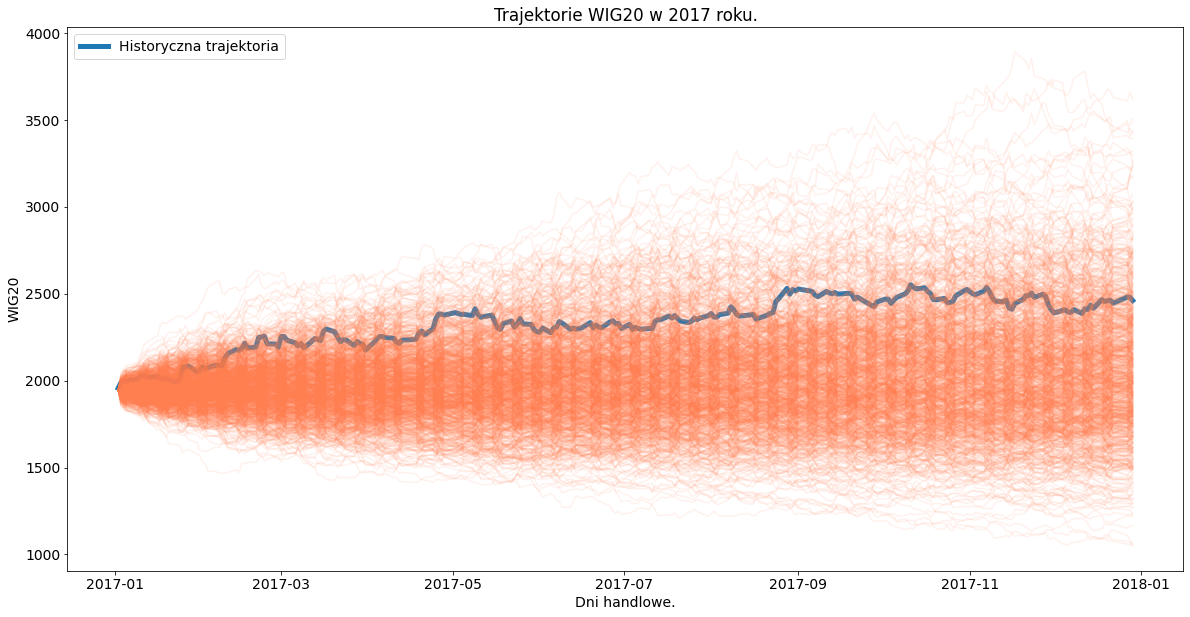

In [ ]:
def make_predictions(last_known_price, mu, sigma, days, num_predictions):
  dt_local=1./days
  # W 2017 mamy 250 dni, a nie 252. To może zaburzać wyniki. GB
  predictions = np.full((num_predictions, days), last_known_price)
  for i in range(0, num_predictions):
    x = np.random.normal(scale=math.sqrt(dt_local),size=days)
    x = x.cumsum()
    for j in  range(1, days):
      #predictions[i][j] = predictions[i][j-1] * (1. + mu*dt_local + sigma * math.sqrt(dt_local)*np.random.normal())
      predictions[i][j] = predictions[i][0]*math.exp((mu - (sigma**2)/2)*j/days + sigma*x[j])
  return predictions


#funkcja zadająca geometryczny ruch Browna
def fquantile(x, mu,sigma,c,t):
  return c*math.exp((mu - sigma**2/2)*t + sigma*math.sqrt(t)*x)

#funkcja generująca kwantyle teoretyczne
def quantile_lines(last_known_price, mu,sigma,percentiles,td):
  x = np.full((len(percentiles), td), last_known_price)
  for i in range(0,len(percentiles)-1):
    for j in range(1,td):
      x[i][j] = fquantile(stats.norm.ppf(percentiles[i]),mu,sigma,last_known_price,j)
  return x


# Prawdziwe dane z 2017r.
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2018-01-01')
wig_20_daily_2017 = wig_20_daily_all.loc[(wig_20_daily_all['Date'] >= start_date) & (wig_20_daily_all['Date'] < end_date)]


last_known_price = wig_20_daily_td.iloc[-1]['Close']
trading_days_2017 = len(wig_20_daily_2017.index)
num_predictions = 1000      # Chyba tyle jest ok, ale może nawet więcej?    GB

predicted = make_predictions(last_known_price, mu, sigma, trading_days_2017, num_predictions)


# Wykres
x = wig_20_daily_2017['Date']
true_prices =  wig_20_daily_2017['Close']

plt.figure(figsize=(20,10))
plt.plot(x, true_prices, label = 'Historyczna trajektoria', linewidth=5)
plt.plot(x, predicted.T, color = 'coral', alpha=0.1)
plt.title('Trajektorie WIG20 w 2017 roku.')
plt.xlabel('Dni handlowe.')
plt.ylabel('WIG20')
plt.legend()
plt.show()



# x = range(0, td)
# plt.plot(x, xd.T, color='r', alpha = 0.3)
# plt.savefig('trajektorie_wig20_predykcje_2017.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('trajektorie_wig20_predykcje_2017.png')

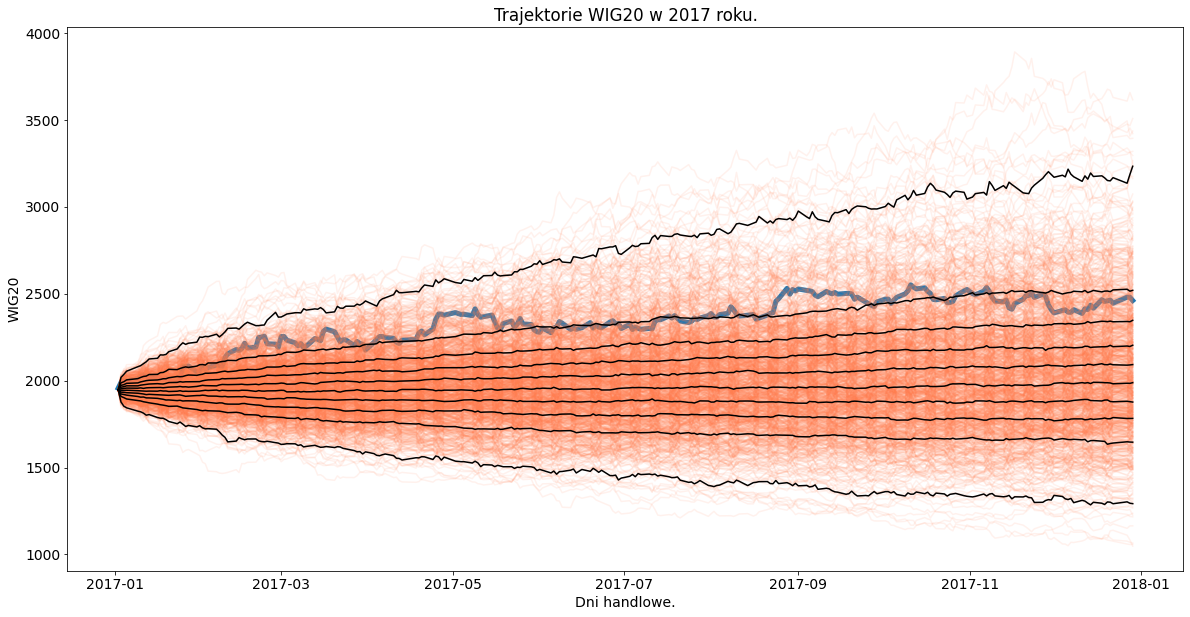

In [ ]:
# Wykres z krzywymi kwantylowymi
x = wig_20_daily_2017['Date']
true_prices =  wig_20_daily_2017['Close']
percentiles = np.linspace(0.01,0.99,10)
q = np.quantile(predicted,percentiles,axis=0)

plt.figure(figsize=(20,10))
plt.plot(x, true_prices, label = 'Historyczna trajektoria', linewidth=5)
plt.plot(x, predicted.T, label = 'Symulacja', color = 'coral', alpha=0.1)
plt.plot(x, q.T,color = 'black',label = 'Linie kwantylowe')
plt.title('Trajektorie WIG20 w 2017 roku.')
plt.xlabel('Dni handlowe.')
plt.ylabel('WIG20')
plt.show()
# plt.savefig('trajektorie_wig20_predykcje_2017_kwantyle.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('trajektorie_wig20_predykcje_2017_kwantyle.png')

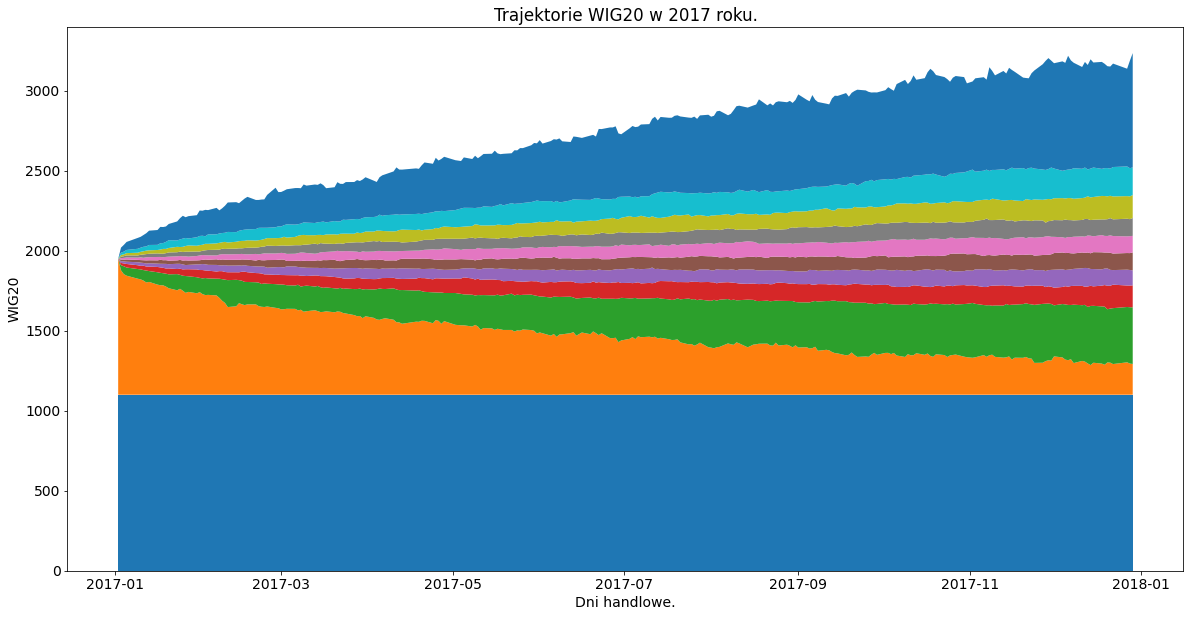

In [ ]:
def levels_to_increments(bottom_line, M):
  """
    Parameters:
      - bottom_line = scalar value
      - M           = matrix n x m. 
    Returns:
      a tuple (x_0, x_1, ..., x_n) of length n + 1, each element of the tuple is a vector of lenght m.
      x_0 = (bottom_line, bottom_line, ..., bottom_line)
      M[k] = x_0 + x_1 + ... + x[k]
  """
  zeros = np.zeros_like(M[0])
  bottom_vec = np.ones_like(M[0]) * bottom_line
  M = np.vstack([zeros, bottom_vec, M])
  increments = [M[i] - M[i-1] for i in range(1, M.shape[0])]
  return increments


# Wykres z krzywymi kwantylowymi
x = wig_20_daily_2017['Date']


plt.figure(figsize=(20,10))

increments = levels_to_increments(1100, q)

plt.stackplot(x , increments , )
plt.title('Trajektorie WIG20 w 2017 roku.')
plt.xlabel('Dni handlowe.')
plt.ylabel('WIG20')
plt.show()

In [ ]:
from plotly.offline import iplot
import plotly.graph_objs as go

data = [
    go.Contour(
        z=q
    )
]
iplot(data)

Histogramy zwrotów dziennych: prawdziwy vs wygenerowany.

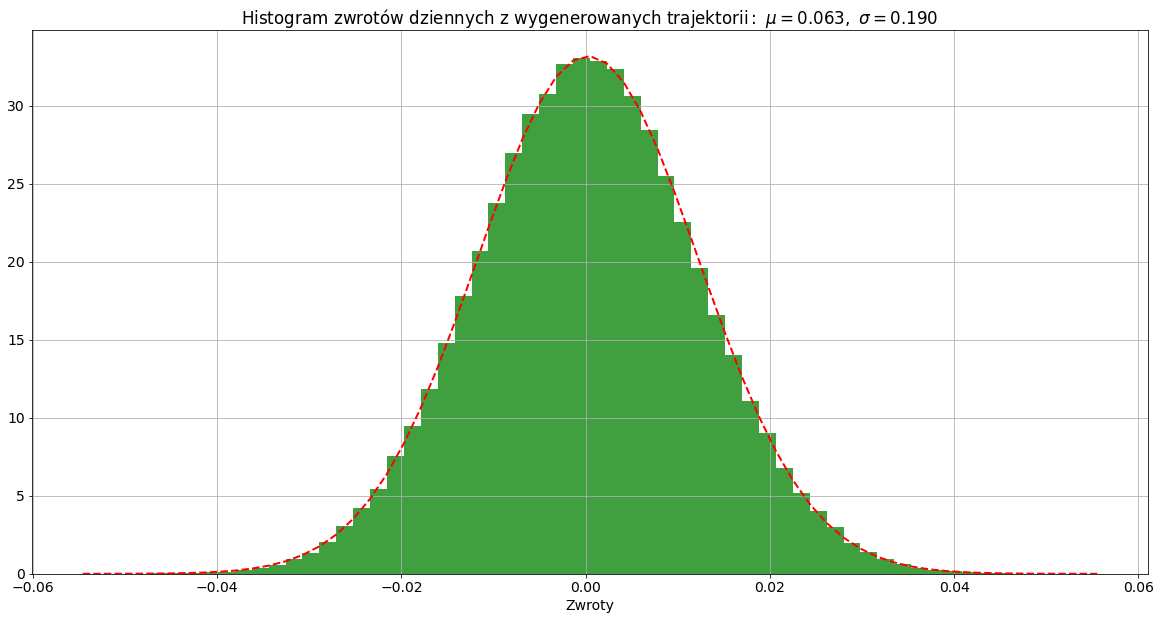

In [ ]:
predictions = pd.DataFrame(predicted.T)
predicted_returns = predictions.pct_change().values.flatten()
predicted_returns = predicted_returns[~np.isnan(predicted_returns)]

# Best fit of data.
(mu_, sigma_) = stats.norm.fit(predicted_returns)

plt.figure(figsize=(20,10))
# The histogram of the data
n, bins, patches = plt.hist(predicted_returns, 60, facecolor='green', alpha=0.75, density=True)

# add a 'best fit' line
y = stats.norm.pdf( bins, mu_, sigma_)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Zwroty')
plt.ylabel('')
plt.title(r'$\mathrm{Histogram\ zwrotów\ dziennych\ z\ wygenerowanych\ trajektorii:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu_ * 250, sigma_ * math.sqrt(250)))
plt.grid(True)

plt.show()
# plt.savefig('hist_wig20_predykcje.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('hist_wig20_predykcje.png')

0.0009809563130522866
0.009499455572315862


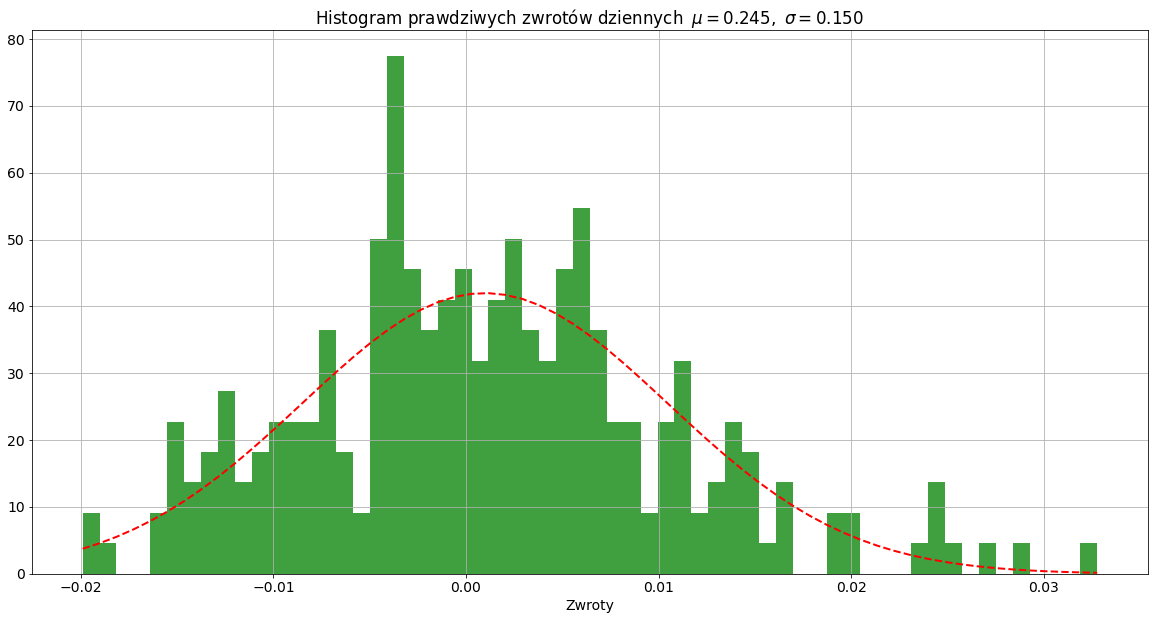

In [ ]:
true_returns = wig_20_daily_2017['Returns'].values # * 20  WTF??
true_returns = true_returns[~np.isnan(true_returns)]

print(true_returns.mean())
print(true_returns.std())

plt.figure(figsize=(20,10))
# Best fit of data.
(mu_, sigma_) = stats.norm.fit(true_returns)

# The histogram of the data
n, bins, patches = plt.hist(true_returns, 60, facecolor='green', alpha=0.75, density=True)

# add a 'best fit' line
y = stats.norm.pdf( bins, mu_, sigma_)
l = plt.plot(bins, y, 'r--', linewidth=2)

#plot
plt.xlabel('Zwroty')
plt.ylabel('')
plt.title(r'$\mathrm{Histogram\ prawdziwych\ zwrotów\ dziennych\: }\ \mu=%.3f,\ \sigma=%.3f$' %(mu_ *250, sigma_  * math.sqrt(250)))
plt.grid(True)

plt.show()
# plt.savefig('hist_wig20_prawdziwe.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('hist_wig20_prawdziwe.png')

In [ ]:
# Stopa zwrotu z obligacji skarbowych o stałym oprocentowaniu TBSP. 
# Dane z https://qnews.pl/pl/news/co-stopy-zwrotu-z-2017-m%C3%B3wi%C4%85-na-temat-nowego-roku
r_2017 = 0.048 

# https://www.obligacjeskarbowe.pl/komunikaty/#year=2016
# Tutaj jest napisane, że dwuletnie obligacje miały oprocentowanie 2,1%

# https://pl.investing.com/rates-bonds/poland-1-year-bond-yield
# A stąd wychodzi 0.017

Symulacje trajektorii WIG_20 i KGHM przy uwzględnieniu ich korelacji.

Wyznaczona korelacja:


In [ ]:



def make_predictions_2(last_known_price_1, last_known_price_2, mu, cov, trading_days, num_predictions):
  predictions_1 = np.full((num_predictions, trading_days), last_known_price_1)
  predictions_2 = np.full((num_predictions, trading_days), last_known_price_2)
  for i in range(0, num_predictions):
    rng = np.random.default_rng()
    norm_wig, norm_kgh = rng.multivariate_normal(mu, cov, trading_days).T
    for j in  range(1, trading_days):
      predictions_1[i][j] = predictions_1[i][j-1] * (1. + norm_wig[j])
      predictions_2[i][j] = predictions_2[i][j-1] * (1. + norm_kgh[j])
  return predictions_1, predictions_2

# Dni handlowe 
trading_days = 252
dt = 1./ trading_days

# Ładujemy dane historyczne.
kgh_daily_url = 'https://raw.githubusercontent.com/krzysztof-kowalski/inz_fin_1/main/kgh_d.csv'
kgh_daily_all = pd.read_csv(kgh_daily_url)
kgh_daily_all['Date'] = pd.to_datetime(kgh_daily_all['Date'])

# Liczymy historyczne zwroty względne.
kgh_daily_all['Returns'] = kgh_daily_all['Close'].pct_change()


# Dane, które używamy do predykcji (td = training data).
start_date = pd.to_datetime('2016-01-01')
end_date = pd.to_datetime('2017-01-01')
kgh_daily_td = kgh_daily_all.loc[(kgh_daily_all['Date'] >= start_date) & (kgh_daily_all['Date'] < end_date)]

# Średnia i kowariancje
mean_wig = wig_20_daily_td['Returns'].mean()
mean_kgh = kgh_daily_td['Returns'].mean()
wig_kgh = np.array([wig_20_daily_td['Returns'], kgh_daily_td['Returns']])
cov_wig_kgh = np.cov(wig_kgh)
corr_wig_kgh = np.corrcoef(wig_kgh)
mean = [mean_wig, mean_kgh]

# Normujemy parametry
mu_wig = mean_wig * trading_days
mu_kgh = mean_kgh * trading_days
sigma_wig = math.sqrt(cov_wig_kgh[0,0]) * math.sqrt(trading_days)
sigma_kgh = math.sqrt(cov_wig_kgh[1,1]) * math.sqrt(trading_days)


#Prawdziwe dane z 2017
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2018-01-01')
kgh_daily_2017 = kgh_daily_all.loc[(kgh_daily_all['Date'] >= start_date) & (kgh_daily_all['Date'] < end_date)]
trading_days_2017 = len(wig_20_daily_2017.index)
true_prices_wig =  wig_20_daily_2017['Close']
true_prices_kgh =  kgh_daily_2017['Close']
last_known_price_wig = wig_20_daily_td.iloc[-1]['Close']
last_known_price_kgh = kgh_daily_td.iloc[-1]['Close']


corr_wig_kgh[1,0]


0.6577524418549081

In [ ]:
mean 

[0.0002572958632930207, 0.0018825312906981108]

In [ ]:
cov_wig_kgh

array([[0.00014328, 0.0001939 ],
       [0.0001939 , 0.00060653]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

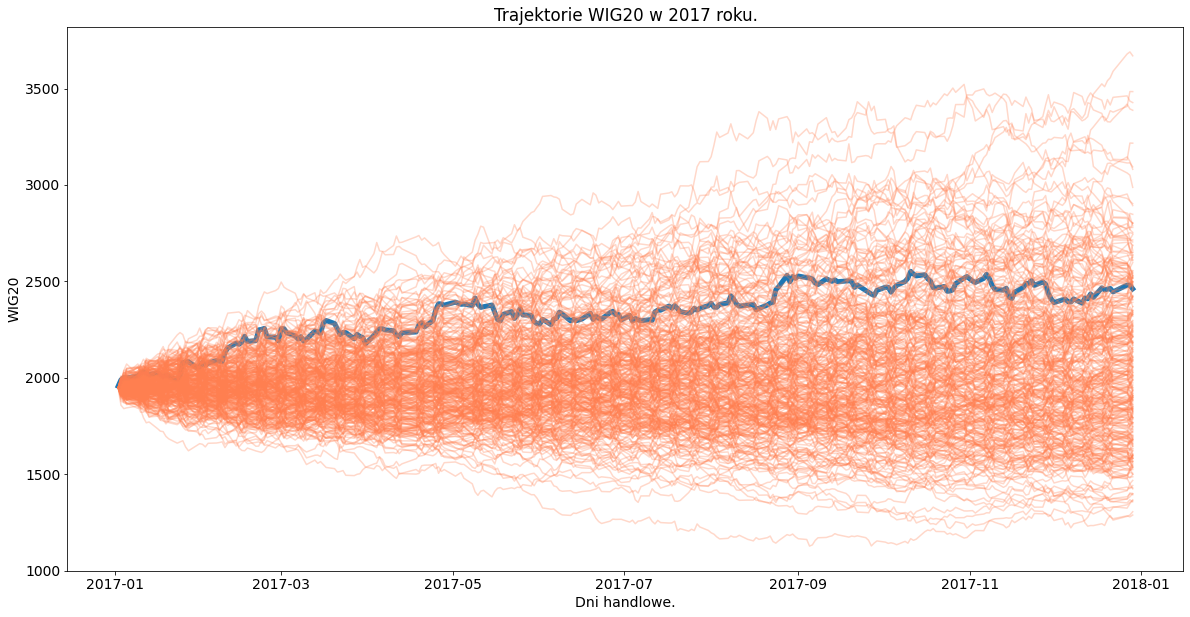

In [ ]:
# Wykresy

predicted_wig, predicted_kgh = make_predictions_2(last_known_price_wig, last_known_price_kgh, mean, cov_wig_kgh, trading_days_2017, 300)

x = wig_20_daily_2017['Date']
true_prices_wig =  wig_20_daily_2017['Close']
true_prices_kgh = kgh_daily_2017['Close']

plt.figure(figsize=(20,10))
plt.plot(x, true_prices_wig, label = 'Historyczna trajektoria', linewidth=5)
plt.plot(x, predicted_wig.T, label = 'Symulacja', color = 'coral', alpha=0.3)
plt.title('Trajektorie WIG20 w 2017 roku.')
plt.xlabel('Dni handlowe.')
plt.ylabel('WIG20')
plt.show()
# plt.savefig('corr_wig.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('corr_wig.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

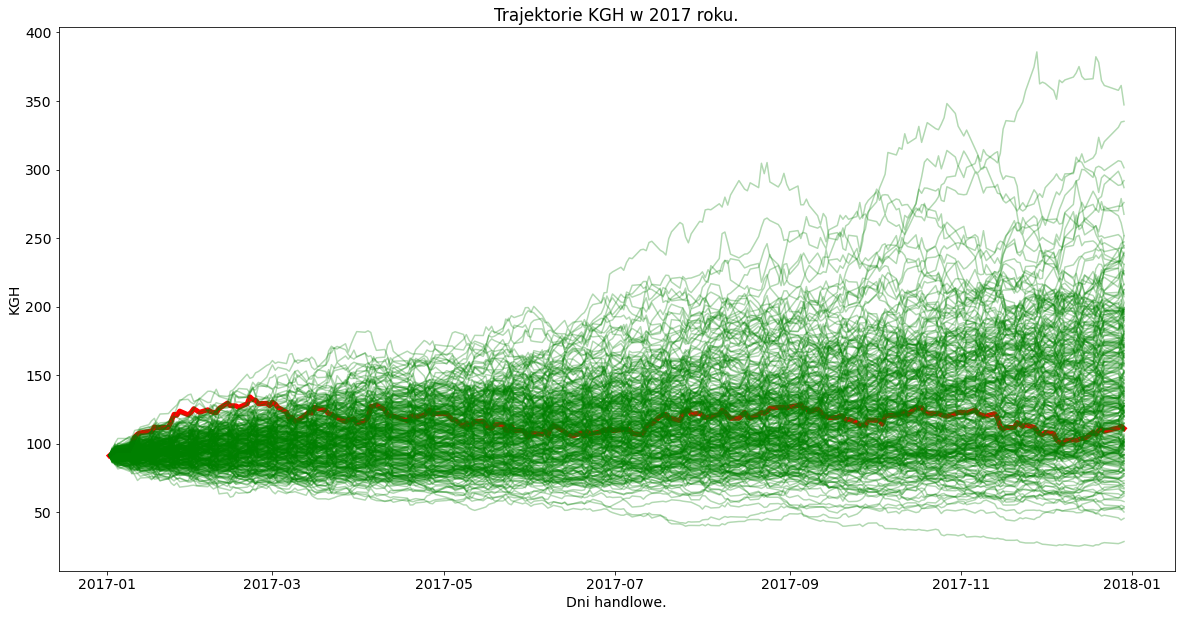

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x, true_prices_kgh, label = 'Historyczna trajektoria', linewidth=5,color='red')
plt.plot(x, predicted_kgh.T, label = 'Symulacja', color = 'green', alpha=0.3)
plt.title('Trajektorie KGH w 2017 roku.')
plt.xlabel('Dni handlowe.')
plt.ylabel('KGH')
plt.show()

# plt.savefig('corr_kghm.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('corr_kghm.png')

Symulacje trajektorii WIG_20 przy pomocy bootstrapa:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

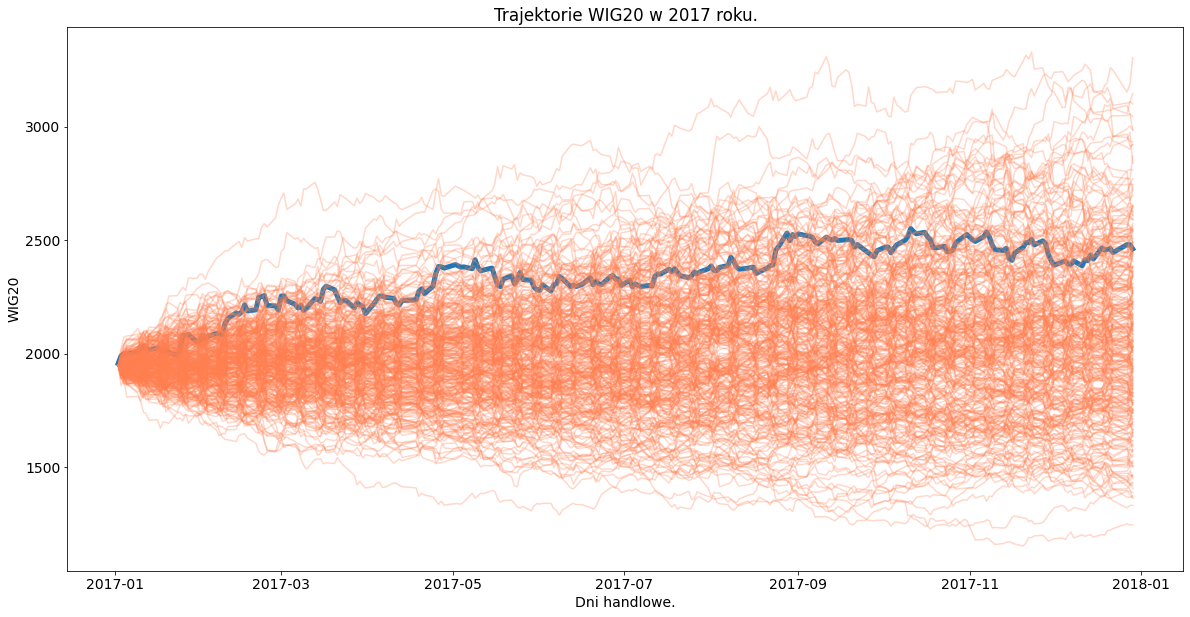

In [ ]:
def make_predictions_bootstrap(last_known_price, historical_data, trading_days, num_predictions):
  predictions = np.full((num_predictions, trading_days), last_known_price)
  for i in range(0, num_predictions):
    bootstrap = np.random.choice(wig_20_daily_td['Returns'], trading_days_2017-1, replace=True)
    for j in  range(1, trading_days):
      predictions[i][j] = predictions[i][j-1] * (1. + bootstrap[j-1])
  return predictions

predicted_wig_bootstrap = make_predictions_bootstrap(last_known_price_wig,wig_20_daily_td,trading_days_2017,300)

plt.figure(figsize=(20,10))
plt.plot(x, true_prices_wig, label = 'Historyczna trajektoria', linewidth=5)
plt.plot(x, predicted_wig_bootstrap.T, label = 'Symulacja', color = 'coral', alpha=0.3)
plt.title('Trajektorie WIG20 w 2017 roku.')
plt.xlabel('Dni handlowe.')
plt.ylabel('WIG20')
plt.show()

# plt.savefig('bootstrapping.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('bootstrapping.png')



Standardy opcji:
- zawsze są dostępne opcje wygasające co miesiąc przez najbliższe 3 miesiące oraz kończące się w trzech następnych miesiącach kończących kwartały (III, VI, IX, XII),
- notowania prowadzi się w punktach indeksowych; jeden punkt jest wart 10 PLN,
- po wygaśnięciu danej serii opcji wprowadza się nowe:
  - wygasające po kwartale (jedne na cenę równą aktualnej, 8 tańszych i 8 niższych)
  - wygasające po miesiącu na cenę równą aktualnej
  - dodatkowo po wygaśnięciu akcji w miesiącach kończących kwartały wprowadza się opcje wygasające po roku (jedne na cenę równą aktualnej, 4 tańsze i 4 droższe)
  - dodatkowo uzupełnia się rynek odpowiednimi seriami tak aby były:
    - odległe o miesiąc: 16 o cenie niższej niż obecna i 16 o cenie wyższej
    - odległe o 2 i 3 miesiące: 8 o cenie niższej niż obecna i 8 o cenie wyższej
    - 4 o cenie niższej niż obecna i 4 o cenie wyższej
  - kolejne ceny wykonania ustala się zgodnie z pkt 1 "Standardu..." - tej tabeli nie będziemy tu zamieszczać,
- premią nazywa się koszt nabycia opcji.

W związku z powyższym, 1 stycznia mamy do dyspozycji 9 opcji zapadających w grudniu. Będziemy rozważać payoffy, więc pomijamy koszt nabycia opcji.

Rozważmy opcję call z ceną 2000 oraz opcje call i put z ceną trzy progi w górę względem wartości zamknięcia indeksu z trzeciego piątku grudnia 2016.

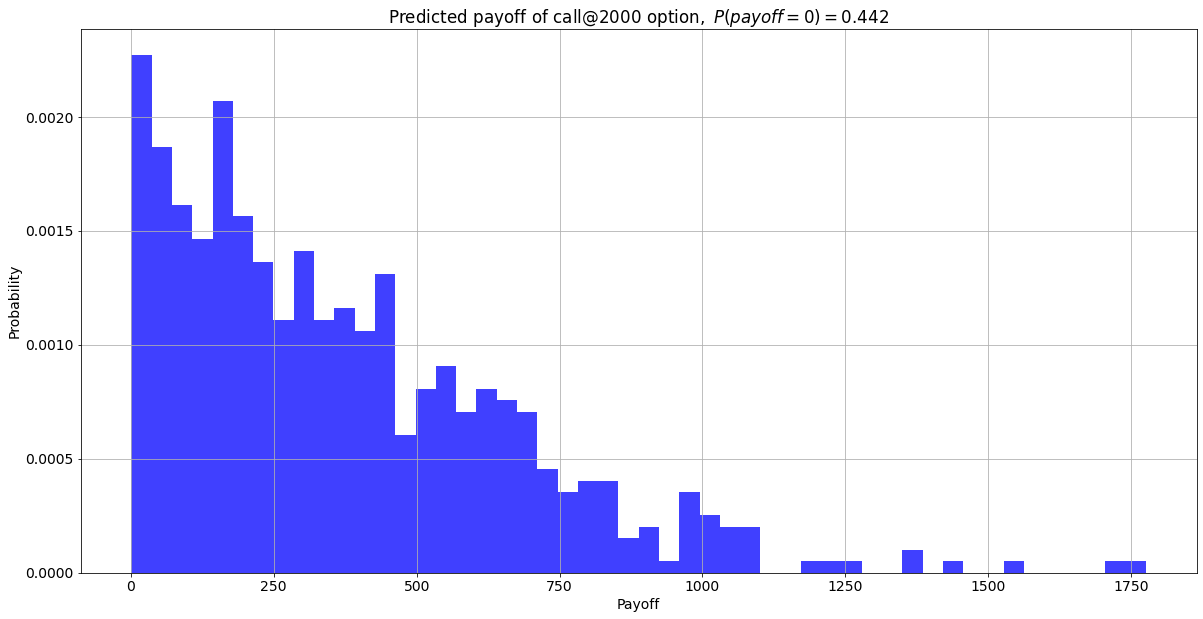

In [ ]:
# Dane do wyznaczenia cen obecnie dostępnych opcji
date_2016 = pd.to_datetime(['2016-01-15','2016-02-19','2016-03-18','2016-04-15','2016-05-20','2016-06-17','2016-07-15','2016-08-19','2016-09-16','2016-10-21','2016-11-18','2016-12-16'])
wig_20_2016_12 = wig_20_daily_all.loc[(wig_20_daily_all['Date'] == date_2016[11])]
cena_odn_12 = wig_20_2016_12['Close']
opcje_21_12 = [1500,1600,1700,1800,1900,2000,2100,2200,2300]

# Liczymy payoffy opcji dostępnych na grudzień
ret_call = np.full((num_predictions, 9), 0)
ret_put = np.full((num_predictions,9),0)
for i in range(0, num_predictions):
  for j in range(0,9):
    ret_call[i][j]=max(predicted[i][246]-opcje_21_12[j],0)
    ret_put[i][j]=max(opcje_21_12[j]-predicted[i][246],0)

# Wyciągamy interesujące nas opcje
ret_call_2000=ret_call.T[5]
ret_call_2200=ret_call.T[7]
ret_put_2200=ret_put.T[7]


# Pstwo że nie wykonamy opcji
P_call_2000_0=sum(ret_call_2000==0)/num_predictions
P_call_2200_0=sum(ret_call_2200==0)/num_predictions
P_put_2200_0=sum(ret_put_2200==0)/num_predictions


plt.figure(figsize=(20,10))
plt.hist(ret_call_2000[ret_call_2000>0], 50, alpha=0.75,facecolor='blue',  density=True)
plt.xlabel('Payoff')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Predicted\ payoff\ of\ call@2000\ option,}\ P(payoff=0)=%.3f$' %(P_call_2000_0))
plt.grid(True)

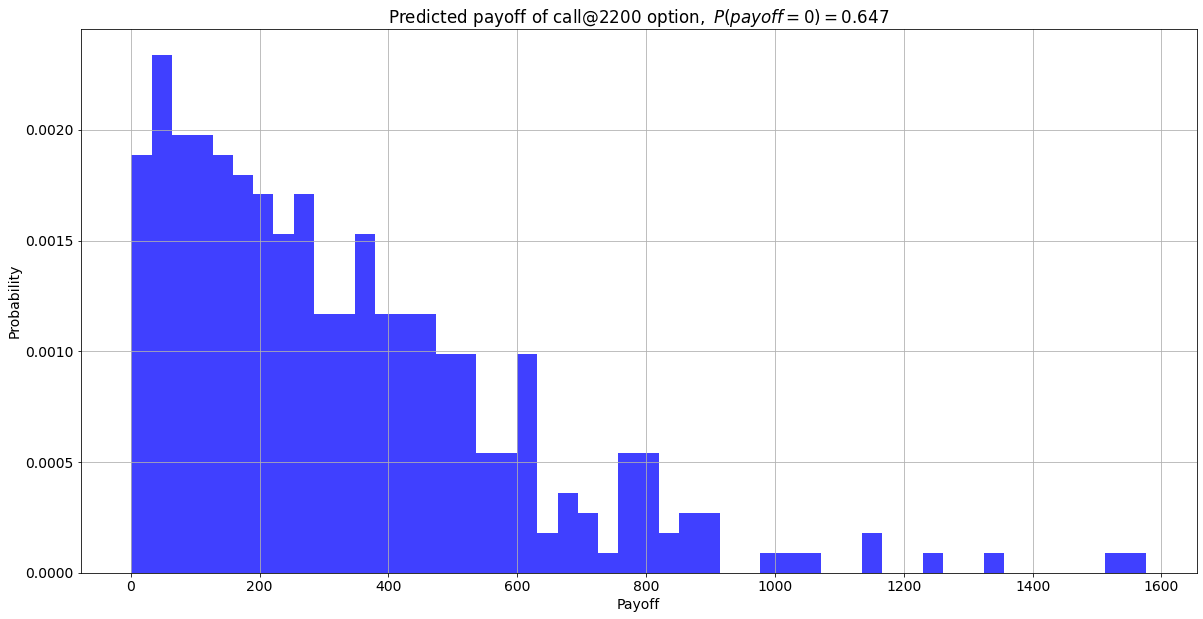

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(ret_call_2200[ret_call_2200>0], 50, alpha=0.75,facecolor='blue',  density=True)
plt.xlabel('Payoff')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Predicted\ payoff\ of\ call@2200\ option,}\ P(payoff=0)=%.3f$' %(P_call_2200_0))
plt.grid(True)


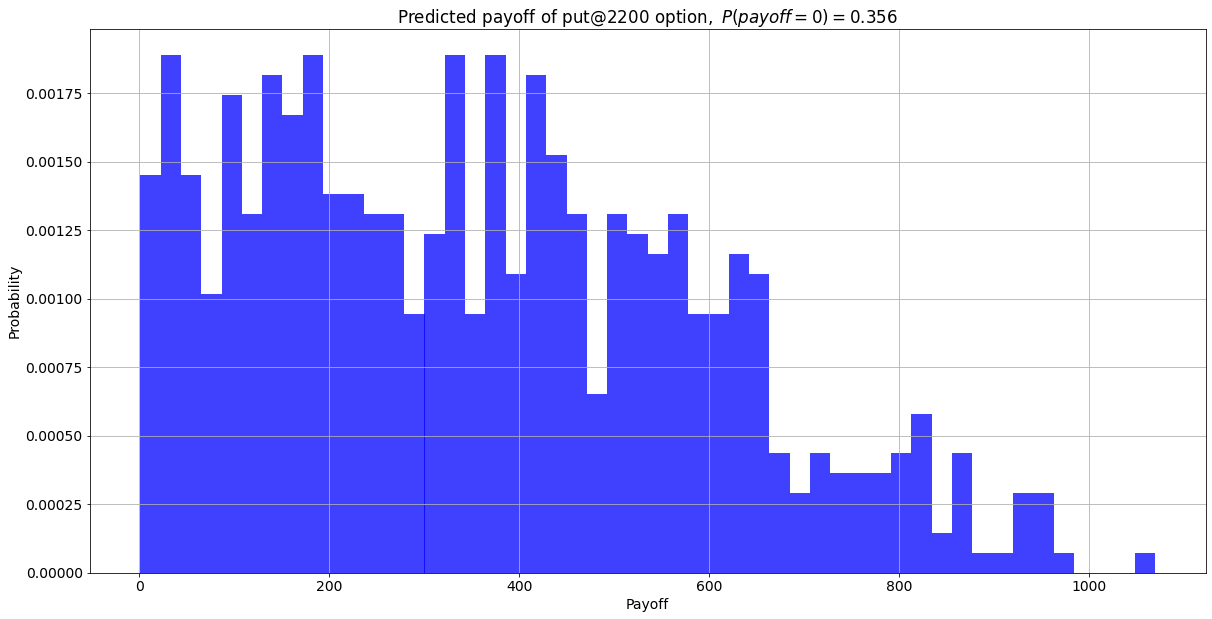

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(ret_put_2200[ret_put_2200>0], 50, alpha=0.75,facecolor='blue',  density=True)
plt.xlabel('Payoff')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Predicted\ payoff\ of\ put@2200\ option,}\ P(payoff=0)=%.3f$' %(P_put_2200_0))
plt.grid(True)


## Część A

Będziemy badać portfel składający się z opcji na indeks, indeksu i pieniędzy (inwestycji wolnej od ryzyka). Skorzystamy z formuły Blacka-Scholesa na cenę opcji call. Mamy:

$$V_{call}=SN(d_1)-Ee^{-r(T-t)}N(d_2),$$
gdzie $N(x)$ jest dystrybuantą rozkładu normalnego, $S$ to obecna cena indeksu, $E$ to strike rozważanej opcji, $r$ to stopa procentowa, $T$ to chwila wykonania, a $t$ to chwila obecna (wyrażane w latach). Dodatkowo,

$d_1=\frac{log(\frac{S}{E})+(r+\frac{\sigma^2}{2})(T-t)} {\sigma \sqrt{T-t}}$ oraz $d_2=d_1-\sigma(T-t)$.

Nie znamy dokładnej wartości $\sigma$, więc korzystamy z tego co wyliczyliśmy na początku na podstawie danych historycznych. Dzięki call-put parity, czyli równaniu $V_{call}+Ee^{-r(T-t)}=V_{put}+S$ wyliczymy cenę odpowiedniej opcji put. Korzystając z liczonych wczesniej trajektorii ceny indeksu, zbadamy rozkład zysku z naszego portfela dla różnych opcji w zależności od liczby rehedgingów. 

In [ ]:
# Poniższe funkcje są dokładnie zaimplementowanymi powyższymi wzorami, łącznie z oznaczeniami
# T i t są datami, czyli wyrażają czas w dniach kalendarzowych, więc normujemy przez 365


def d1(S,E,t,T,si,r):
  return (math.log(S/E)+(r+(si*si)/2)*(T-t)/250)/(sigma*math.sqrt((T-t)/250))

def d2(S,E,t,T,si,r):
  return d1(S,E,t,T,si,r)-si*(T-t)/250

# ceny opcji w chwili t, gdy cena jest S
def vcall(S,E,t,T,si,r):
  V = S*stats.norm.cdf(d1(S,E,t,T,si,r))-E*math.exp(-r*(T-t)/250)*stats.norm.cdf(d2(S,E,t,T,si,r))
  return V

def vput(S,E,t,T,si,r):
  return vcall(S,E,t,T,si,r)+E*math.exp(-r*(T-t)/250)-S

# delta do zabezpieczenia opcji
def delta_call(S,E,t,T,si,r):
  return stats.norm.cdf(d1(S,E,t,T,si,r))

def delta_put(S,E,t,T,si,r):
  return stats.norm.cdf(d1(S,E,t,T,si,r))-1



def call_payoff(price_at_exp, strike):
  return max(0., price_at_exp-strike)

def put_payoff(price_at_exp, strike):
  return max(0., strike - price_at_exp)



In [ ]:
vcall(1500,2400,0,186,0.15,0.02)

-0.5543330279674974

(-1.6103765914104433, 0.526)

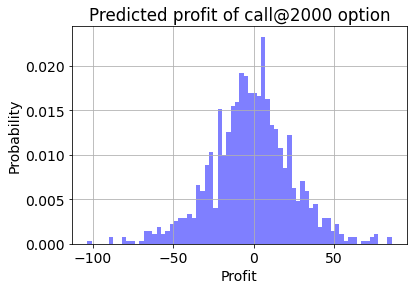

In [ ]:
# Ustalamy datę startu na 01.01. oraz tablicę dni handlowych w 2017
daty_2017=wig_20_daily_2017['Date'].to_numpy()
start_date=pd.to_datetime('2017-01-01')

# Opcja wygasa w trzeci piatek grudnia
expire_date_1712 = pd.to_datetime('2017-12-15')
expire_index=np.where(daty_2017 == expire_date_1712)[0][0]  # index dnia 15.12.2017


def profit_call(strike,trajectories,num,frequency,r,si):
  """ Zakładamy że portfel ma na początku wartość 0. Obliczamy nasz zysk po roku z opcji zabezpieczanej indeksem.
  Parametry:
    strike -        cena strike opcji
    trajectories -  zbiór trajektorii kursu indeksu. Tabela wymiarów (num, trading_days_2017)
    num -           liczba rozważanych trajektorii, j.w.
    frequency -     co ile dni giełdowych aktualizujemy portfel
    r -             stopa procentowa nie obciążona ryzykiem
    si -            sigma, zmienność rozważanego indeksu
  Return:
    cash -          tablica długości num, zawierająca wartość portfela dnia wygaśnięcia po zamknięciu wszystkich pozycji
  """
  # Delta na początku jest we wszystkich portfelach taka sama - zależy od ostatniej znanej ceny, która jest wspólna dla wszystkich trajektorii
  delta=np.full(num, delta_call(trajectories[0][0],strike,0,expire_index,si,r))
  # Początkowy cash też nie zależy od wyboru trajektorii, bo cena opcji od niej nie zależy
  # Sprzedajemy opcję, więc mamy z niej dodatnie pieniądze. W takim razie potrzebujemy kupić delta sztuk indeksu (na odwrót niż w standardowo opisywanym modelu)
  cash=np.full(num, vcall(trajectories[0][0],strike,0,expire_index,si,r) - delta[0]*trajectories[0][0] )
  i=frequency
  while i<expire_index:
    for j in range(0,num):
      # Nowa delta
      d = delta_call(trajectories[j][i],strike,i,expire_index,si,r)
      # Skapitalizowane posiadane pieniądze pomniejszone o cenę sprzedanego indeksu w ilości d-delta[j]
      # frequency jest w dniach giełdowych, więc normalizujemy przez 250.
      cash[j] = cash[j]*math.exp(r*frequency/trading_days_2017) - (d-delta[j])*trajectories[j][i]
      delta[j] = d
    i = i + frequency
  i = i - frequency
  # Ile dni przed zapadnięciem odbył się ostatni rehedging.
  rest=expire_index-i
  # Spieniężamy portfel
  for j in range(0,num):
    payoff=max(trajectories[j][expire_index]-strike,0)
    cash[j]=cash[j]*math.exp(r*rest/trading_days_2017) + delta[j]*trajectories[j][expire_index] - payoff
  return cash


test=profit_call(2000,predicted,num_predictions,10,r_2017,sigma)


plt.hist(test, 70, alpha=0.5, facecolor='blue', density=True)
plt.xlabel('Profit')
plt.ylabel('Probability')
plt.title(r'Predicted profit of call@2000 option')
plt.grid(True)

# Średni profit, prawdopodobieństwo wyjścia na minus
sum(test)/num_predictions, sum(test<0)/num_predictions

## Zyski i straty w zależności od liczny rehedgingów.

In [ ]:
rehedge_frequencies = [30,15,7,3,1]
cash = [profit_call(2000,predicted,num_predictions,frequency,r_2017,sigma) for frequency in rehedge_frequencies]
avg_cash = [sum(predicted_cash)/num_predictions for predicted_cash in cash]
likelihood_negative_cash = [sum(predicted_cash<0)/num_predictions for predicted_cash in cash]
sd_cash=[predicted_cash.std() for predicted_cash in cash]

In [ ]:
# print(avg_cash)
# print(likelihood_negative_cash)
pd.DataFrame(data=np.array([rehedge_frequencies, avg_cash, likelihood_negative_cash, sd_cash]).T, columns=['rehedge_frequencies', 'avg_cash', 'likelihood_negative_cash', 'sd_cash'])

,rehedge_frequencies,avg_cash,likelihood_negative_cash,sd_cash
0,30.0,-3.249274,0.519,42.755936
1,15.0,-1.481419,0.525,30.629964
2,7.0,-1.758192,0.550,21.834322
3,3.0,-2.820223,0.600,14.564879
4,1.0,-2.569991,0.635,8.823088


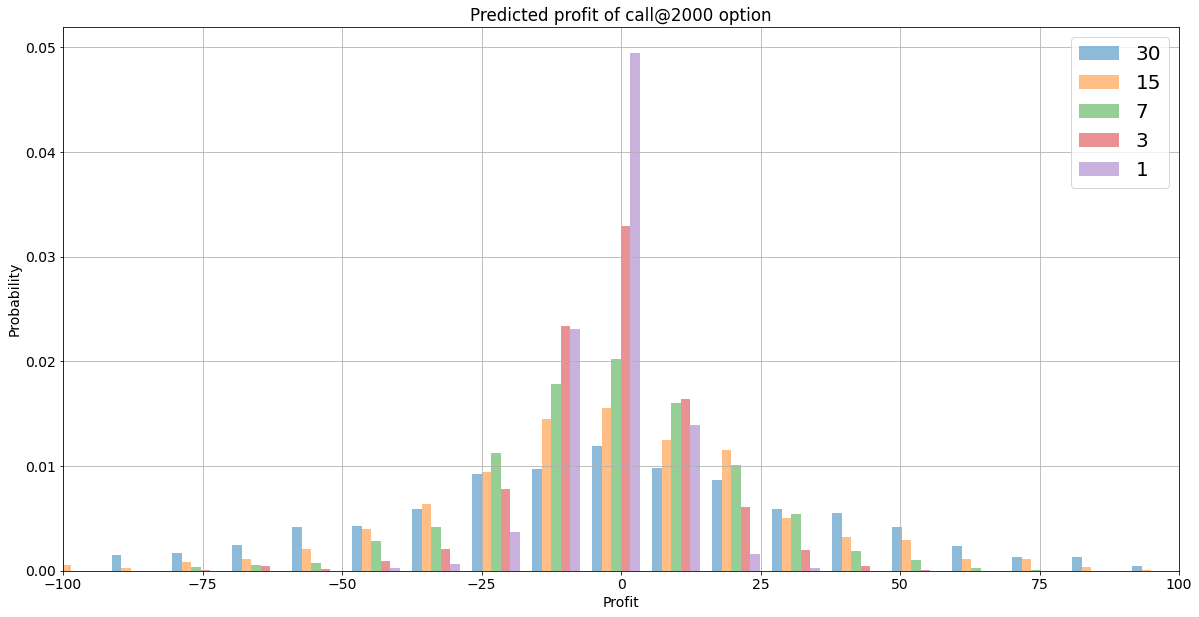

In [ ]:
plt.figure(figsize=(20,10))
plt.hist(cash, 30, alpha=0.5, density=True, label=rehedge_frequencies)
plt.xlim(-100,100)
plt.xlabel('Profit')
plt.ylabel('Probability')
plt.title(r'Predicted profit of call@2000 option')
plt.legend(prop={'size': 20})
plt.grid(True)

In [ ]:
# Wyznaczamy kwantyle zysku/straty dla powyższych symulacji
predicted_quantiles=np.full((7,5),0)
quantiles_list=[0.01,0.05,0.1,0.5,0.9,0.95,0.99]
for tmp in range(0,5):
  cash[tmp].sort()
  for i in range(0,7):
    predicted_quantiles[i][tmp]=cash[tmp][int(num_predictions*quantiles_list[i])]
pd.DataFrame(data=np.array([rehedge_frequencies, predicted_quantiles[0],predicted_quantiles[1],predicted_quantiles[2]]).T, columns=['rehedge_frequencies', quantiles_list[0],quantiles_list[1],quantiles_list[2]])

,rehedge_frequencies,0.01,0.05,0.1
0,30,-120,-73,-55
1,15,-83,-51,-38
2,7,-62,-38,-27
3,3,-46,-24,-19
4,1,-27,-16,-12


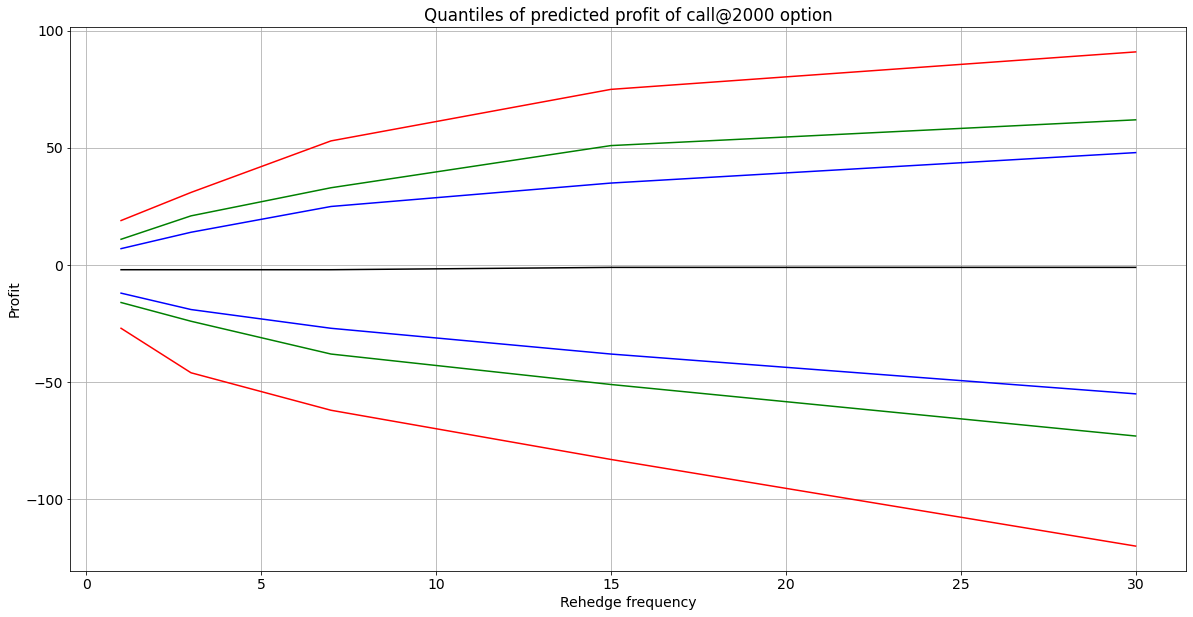

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rehedge_frequencies,predicted_quantiles[0],'r', rehedge_frequencies,predicted_quantiles[1],'g', rehedge_frequencies,predicted_quantiles[2],'b', rehedge_frequencies,predicted_quantiles[3],'black', rehedge_frequencies,predicted_quantiles[4],'b', rehedge_frequencies,predicted_quantiles[5],'g', rehedge_frequencies,predicted_quantiles[6],'r', )
#plt.xlim(-100,100)
plt.xlabel('Rehedge frequency')
plt.ylabel('Profit')
plt.title(r'Quantiles of predicted profit of call@2000 option')
plt.grid(True)

In [ ]:
# Wyliczamy o ile musi się różnić sigma (w związku z tym, cena naszej opcji), żeby zmniejszyć prawdopodobieństwo ujemnego rezultatu do akceptowalnego poziomu
sigma_mult=[1*sigma,1.05*sigma,1.1*sigma,1.12*sigma,1.15*sigma]

call_prices=[vcall(last_known_price,2000,0,expire_index,si,r_2017) for si in sigma_mult]
[(call_prices[i]-call_prices[0])*math.exp(r_2017*expire_index/250) for i in range(1,5)]/call_prices[0], 17/call_prices[0]

TypeError: ignored

Widzimy, że premia na poziome 14 PLN (ok. 9% ceny) jest akceptowalna (wystarczy że w czyimś modelu $\sigma$ różni się o 10%), a dla nas oznacza zmniejszenie prawdopodobieństwa straty poniżej 0.1. Jeżeli ktoś byłby skłonny zapłacić dodatkowe 17 PLN ($\sigma$ większa o 12%, cena o ok. 10,8%), to prawdopodobieństwo straty zmniejszamy do 0.05.

## Świat rzeczywisty

In [ ]:
rehedge_frequencies = range(1,31)
true_prices =  wig_20_daily_2017['Close'].to_numpy()
true_cash = [profit_call(2000,[true_prices],1,frequency,r_2017,sigma) for frequency in rehedge_frequencies]

In [ ]:
pd.DataFrame(data=np.array([rehedge_frequencies, true_cash]).T, columns=['rehedge_frequencies', 'true_cash'])

,rehedge_frequencies,true_cash
0,1,[8.003571602926286]
1,2,[5.468865327549565]
2,3,[8.99032204541868]
3,4,[10.711534133485202]
4,5,[12.752593354633973]
5,6,[6.554091545978508]
6,7,[11.396519878003573]
7,8,[11.510167034677579]
8,9,[5.8659464618854145]
9,10,[11.106167914105527]


No handles with labels found to put in legend.


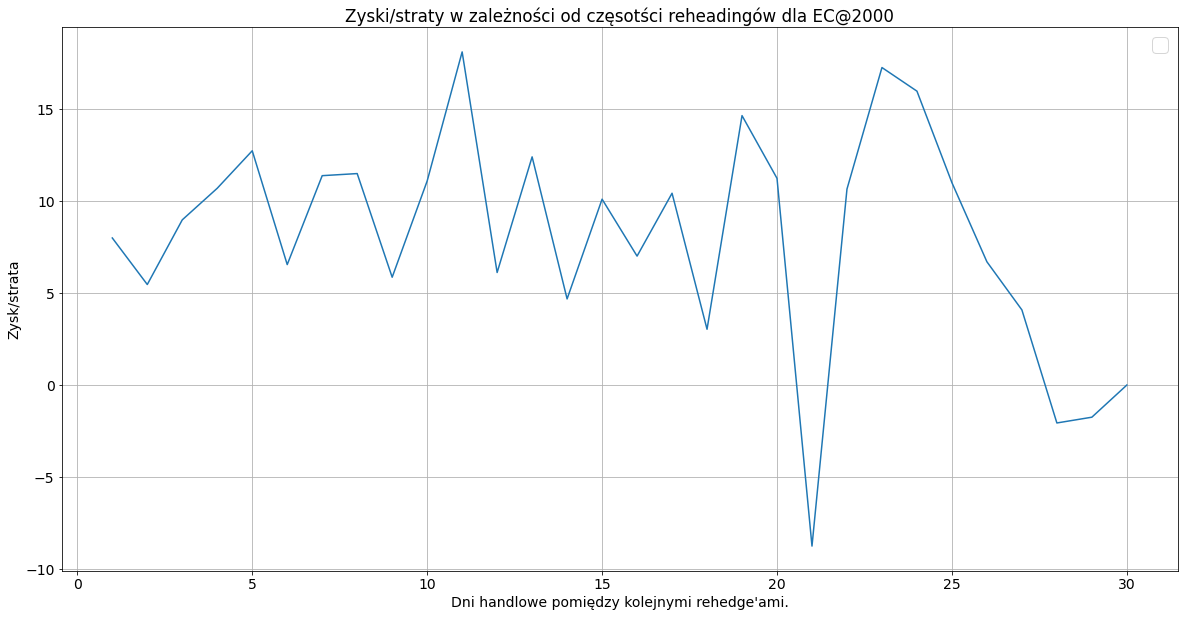

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(rehedge_frequencies, true_cash)
plt.xlabel('Dni handlowe pomiędzy kolejnymi rehedge\'ami.')
plt.ylabel('Zysk/strata')
plt.title(r'Zyski/straty w zależności od częsotści reheadingów dla EC@2000')
plt.legend(prop={'size': 20})
plt.grid(True)
# plt.savefig('EC@2000_zyski_od_czestosci_reheadge.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('EC@2000_zyski_od_czestosci_reheadge.png')

In [ ]:
def euro_option_details(value_func, delta_func,  payoff_func, strike,true_prices,frequency,r,si):
  """ Zakładamy że portfel ma na początku wartość 0. Obliczamy nasz zysk po roku z opcji zabezpieczanej indeksem.
  Parametry:
    value_func -    funkcja do liczenia wartości opcji
    delta_func -    funkcja do liczenia delty dla danej opcji
    payoff_func -    funkcja do liczenia payoffu opcji
    strike -        cena strike opcji
    true_prices -   prawdziwy kurs indeksu w 2017r. Tabela długości ( trading_days_2017)
    frequency -     co ile dni giełdowych aktualizujemy portfel
    r -             stopa procentowa nie obciążona ryzykiem
    si -            sigma, zmienność rozważanego indeksu
  Return:
    (cash, delta, portfolio_value) - trzy tablice, każda długości (trading_days_2017).
        - cash - ile mamy gotówki w danej chwili 
        - delta - ile mamy indeksu w danej chwili
        - portfolio_value - jaka jest wartość naszego portfela w danej chwili
  """

  delta = np.zeros(expire_index+1)
  cash = np.zeros_like(delta)
  portfolio_value = np.zeros_like(delta)


  # Delta na początku.
  delta[0] = delta_func(true_prices[0],strike,0,expire_index,si,r)
  # Początkowy cash też nie zależy od wyboru trajektorii, bo cena opcji od niej nie zależy
  # Sprzedajemy opcję, więc mamy z niej dodatnie pieniądze. W takim razie potrzebujemy kupić delta sztuk indeksu (na odwrót niż w standardowo opisywanym modelu)
  cash[0] = value_func(true_prices[0],strike,0,expire_index,si,r) - delta[0]*true_prices[0]
  for i in range(1, expire_index):
    if i % frequency == 0:
      new_delta = delta_func(true_prices[i],strike,i,expire_index,si,r)
      new_cash = cash[i-1]*math.exp(r*frequency/trading_days_2017) - (new_delta-delta[i-1])*true_prices[i]
      cash[i] = new_cash
      delta[i] = new_delta
      portfolio_value[i] = cash[i] + delta[i]*true_prices[i] - value_func(true_prices[i],strike,i,expire_index,si,r) 
    else:
      cash[i] = cash[i-1]
      delta[i] = delta[i-1]
      portfolio_value[i] = portfolio_value[i-1]

  # Ile dni przed zapadnięciem odbył się ostatni rehedging.
  rest =  expire_index % frequency   
  # Spieniężamy portfel
  payoff=payoff_func(true_prices[expire_index], strike)
  cash[expire_index]=cash[expire_index-1]*math.exp(r*rest/250.) + delta[expire_index-1]*true_prices[expire_index] - payoff
  delta[expire_index] = 0.
  portfolio_value[expire_index] = cash[expire_index]
  return (cash, delta, portfolio_value)


def euro_call_details(strike,true_prices,frequency,r,si):
  return euro_option_details(vcall, delta_call,  call_payoff, strike,true_prices,frequency,r,si)

def euro_put_details(strike,true_prices,frequency,r,si):
  return euro_option_details(vput, delta_put,  put_payoff, strike,true_prices,frequency,r,si)


In [ ]:
true_prices =  wig_20_daily_2017['Close'].to_numpy()
(true_call_cash, true_call_delta, true_call_portfolio_value) = euro_call_details(2000, true_prices, 10, r_2017, sigma)
(true_put_cash, true_put_delta, true_put_portfolio_value) = euro_put_details(2000, true_prices, 10, r_2017, sigma)

Poniższy wykres zmiany $\Delta_{call}(t)$ i $\Delta_{put}(t) $ zgadza się ze wzorami teoretycznymi
$$
\Delta_{call}(t) = N(d_1)
$$

$$
\Delta_{put}(t) = N(d_1) - 1
$$

In [ ]:
# wig_20_daily_2017

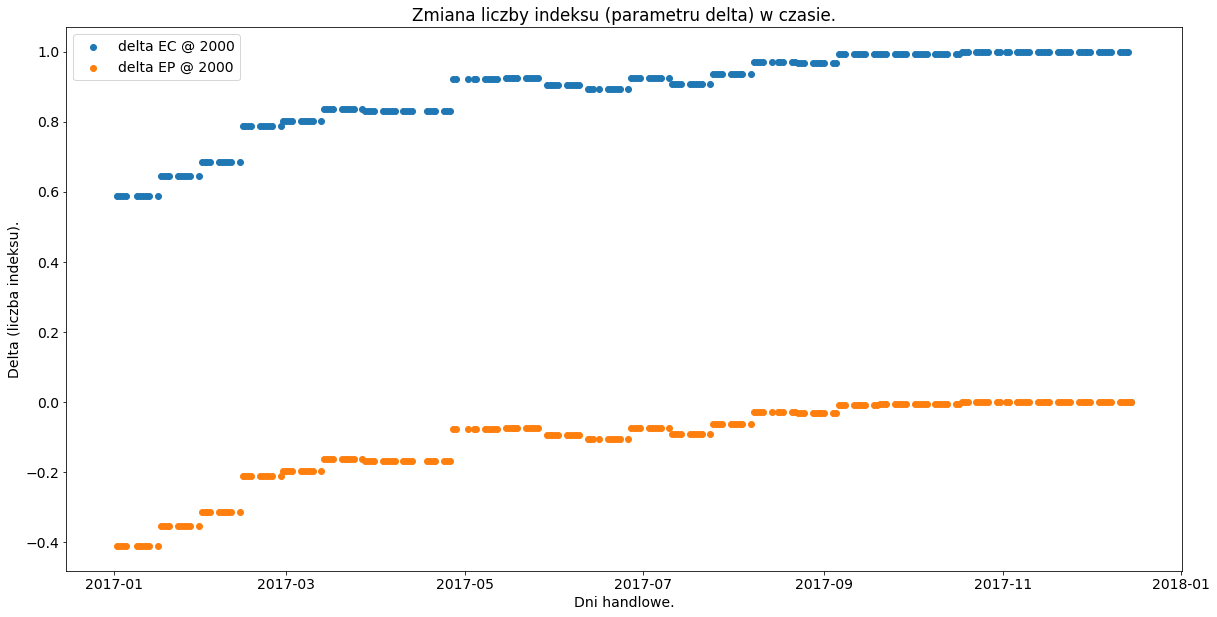

In [ ]:
# Wykres: Zmiana liczby indeksu ( parametru delta) w czasie 
x = wig_20_daily_2017['Date'][:len(true_call_delta)]

plt.figure(figsize=(20,10))
plt.scatter(x, true_call_delta, label = 'delta EC @ 2000')
plt.scatter(x, true_put_delta, label = 'delta EP @ 2000')
plt.title('Zmiana liczby indeksu (parametru delta) w czasie.')
plt.xlabel('Dni handlowe.')
plt.ylabel('Delta (liczba indeksu).')
plt.legend()
plt.show()
# plt.savefig('sklad_portfela_w_czasie.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('sklad_portfela_w_czasie.png')

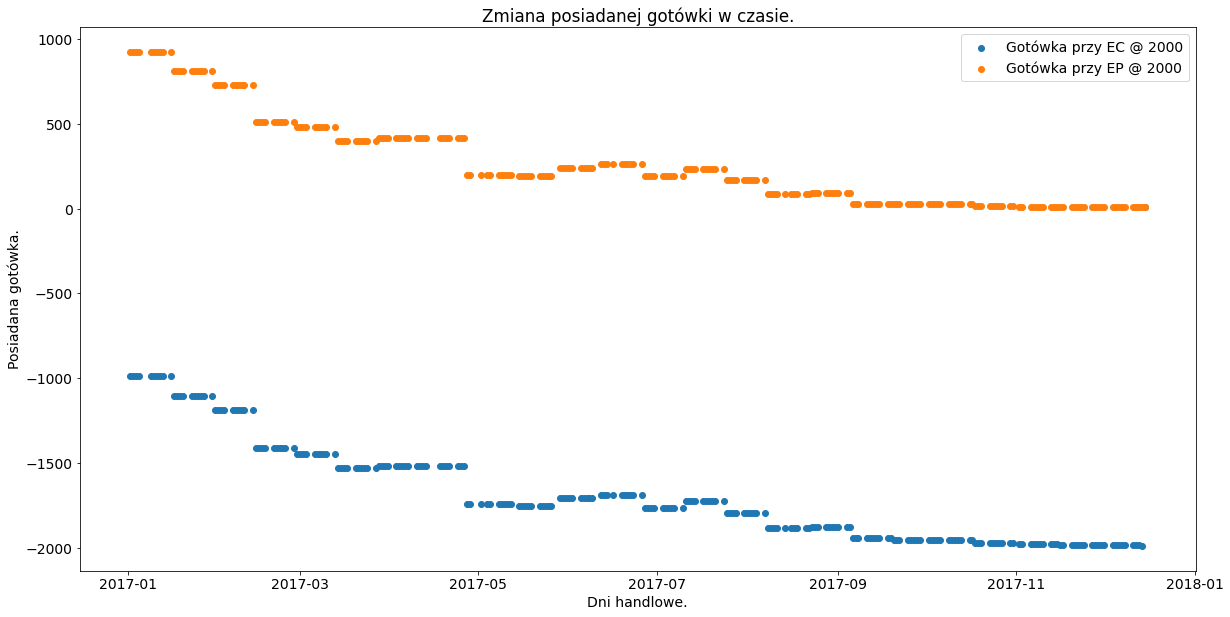

In [ ]:
# Wykres: Zmiana posiadanej gotówki w czasie.
x = wig_20_daily_2017['Date'][:len(true_call_delta)]

plt.figure(figsize=(20,10))
plt.scatter(x, true_call_cash, label = 'Gotówka przy EC @ 2000')
plt.scatter(x, true_put_cash, label = 'Gotówka przy EP @ 2000')
plt.title('Zmiana posiadanej gotówki w czasie.')
plt.xlabel('Dni handlowe.')
plt.ylabel('Posiadana gotówka.')
plt.legend()
plt.show()

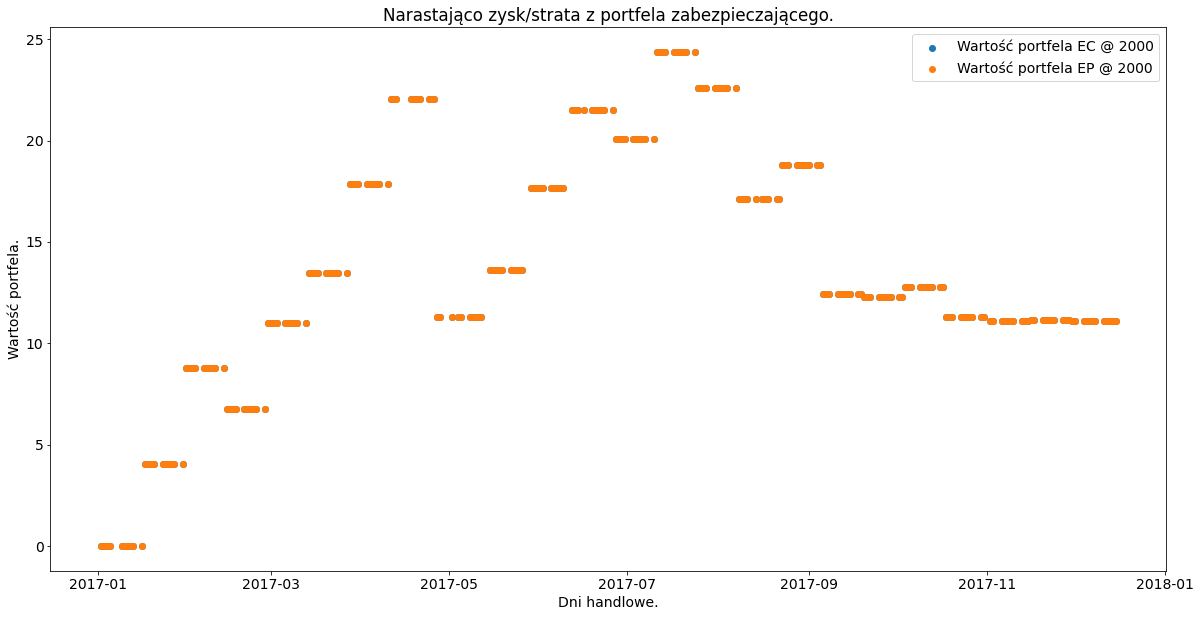

In [ ]:
# Wykres: Narastająco zysk/strata z portfela zabezpieczającego. 
x = wig_20_daily_2017['Date'][:len(true_call_delta)]

plt.figure(figsize=(20,10))
plt.scatter(x, true_call_portfolio_value, label = 'Wartość portfela EC @ 2000')
plt.scatter(x, true_put_portfolio_value, label = 'Wartość portfela EP @ 2000')
plt.title('Narastająco zysk/strata z portfela zabezpieczającego.')
plt.xlabel('Dni handlowe.')
plt.ylabel('Wartość portfela.')
plt.legend()
plt.show()
# plt.savefig('narastajaco_zysk_delta_hedge.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('narastajaco_zysk_delta_hedge.png')

## Część B:

In [ ]:
def vbinarycall(S,E,t,T,si,r):
  V = math.exp(-r*((T-t)/250)*stats.norm.cdf(d2(S,E,t,T,si,r)))
  return V

def vbinaryput(S,E,t,T,si,r):
  V = math.exp(-r*((T-t)/250)*(1-stats.norm.cdf(d2(S,E,t,T,si,r))))
  return V

def delta_binarycall(S,E,t,T,si,r):
  return (math.exp(-r*((T-t)/250))*stats.norm.pdf(d2(S,E,t,T,si,r)))/(si*S*math.sqrt((T-t)/250))

def delta_binaryput(S,E,t,T,si,r):
  return -(math.exp(-r*((T-t)/250))*stats.norm.pdf(d2(S,E,t,T,si,r)))/(si*S*math.sqrt((T-t)/250))

def gamma_call(S,E,t,T,si,r):
  return stats.norm.pdf(d1(S,E,t,T,si,r))/(si*S*math.sqrt((T-t)/250))

def gamma_put(S,E,t,T,si,r):
  return stats.norm.pdf(d1(S,E,t,T,si,r))/(si*S*math.sqrt((T-t)/250))

def gamma_binarycall(S,E,t,T,si,r):
  return -(math.exp(-r*((T-t)/250))*d1(S,E,t,T,si,r)*stats.norm.pdf(d2(S,E,t,T,si,r)))/(si**2 * S**2 * math.sqrt((T-t)/250))

def gamma_binaryput(S,E,t,T,si,r):
  return (math.exp(-r*((T-t)/250))*d1(S,E,t,T,si,r)*stats.norm.pdf(d2(S,E,t,T,si,r)))/(si**2 * S**2 * math.sqrt((T-t)/250))

def b(gamma1,gamma2):
  return gamma1/gamma2

def a(delta1,delta2,b):
  return delta1 - b*delta2

def binarycall_payoff(price_at_exp, strike):
  return 1 if price_at_exp > strike else 0

def binaryput_payoff(price_at_exp, strike):
  return 0 if price_at_exp > strike else 1


def profit_gamma_call(strike1, exp_date_1, value1, payoff1, delta1, gamma1, 
                      strike2, exp_date_2, value2, payoff2, delta2, gamma2, 
                      trajectories,num,frequency,r,si):
  """ Zakładamy że portfel ma na początku wartość 0. Obliczamy nasz zysk po roku z opcji zabezpieczanej indeksem.
  Parametry:
    strike1, exp_date_1 - cena strike i data wygaśnięcia  opcji głównej
    strike2, exp_date_2 - cena strike i data wygaśnięcia opcji używanej do zabezpieczenia portfela
    value1, payoff1, delta1, gamma1 - odpowiednie funkcje dla opcji głównej
    value2, payoff2, delta2, gamma2 - odpowiednie funkcje dla opcji zabezpieczającej
    trajectories -  zbiór trajektorii kursu indeksu. Tabela wymiarów (num, trading_days_2017)
    num -           liczba rozważanych trajektorii, j.w.
    frequency -     co ile dni giełdowych aktualizujemy portfel
    r -             stopa procentowa nie obciążona ryzykiem
    si -            sigma, zmienność rozważanego indeksu
  Return:
    cash -          tablica długości num, zawierająca wartość portfela dnia wygaśnięcia po zamknięciu wszystkich pozycji
  """
    # Ustalamy datę startu na 01.01. oraz tablicę dni handlowych w 2017
  daty_2017=wig_20_daily_2017['Date'].to_numpy()
  start_date=pd.to_datetime('2017-01-01')

  # Opcja wygasa w trzeci piatek grudnia
  expire_date1 = pd.to_datetime(exp_date_1)
  expire_date2 = pd.to_datetime(exp_date_2)
  expire_index1=np.where(daty_2017 == expire_date1)[0][0]  # index dnia 15.12.2017
  expire_index2=np.where(daty_2017 == expire_date2)[0][0]  # index dnia 15.12.2017
  
  # parametry a,b na początku są we wszystkich portfelach takie same
  g1 = gamma1(trajectories[0][0], strike1, 0, expire_index1, si, r)
  g2 = gamma2(trajectories[0][0], strike2, 0, expire_index2, si, r)
  d1 = delta1(trajectories[0][0], strike1, 0, expire_index1, si, r)
  d2 = delta2(trajectories[0][0], strike2, 0, expire_index2, si, r)
  bt=np.full(num, b(g1,g2))
  at=np.full(num, a(d1,d2,bt))

  # Początkowy cash też nie zależy od wyboru trajektorii, bo cena opcji od niej nie zależy
  # Sprzedajemy opcję, więc mamy z niej dodatnie pieniądze. W takim razie potrzebujemy kupić delta sztuk indeksu (na odwrót niż w standardowo opisywanym modelu)

  transaction = value1(trajectories[0][0],strike1,0,expire_index1,si,r) - at[0]*trajectories[0][0] - bt[0]*value2(trajectories[0][0], strike2,0,expire_index2,si,r)

  cash=np.full(num, transaction - 0.04* abs( value1(trajectories[0][0],strike1,0,expire_index1,si,r) ) -0.04 * abs(at[0]*trajectories[0][0]) -0.04 * abs(bt[0]*value2(trajectories[0][0], strike2,0,expire_index2,si,r)) )

  i=frequency
  while i<expire_index1:
    for j in range(0,num):
      # Nowe delta/gamma/a/b
      g1 = gamma1(trajectories[j][i], strike1, i, expire_index1, si, r)
      g2 = gamma2(trajectories[j][i], strike2, i, expire_index2, si, r)
      d1 = delta1(trajectories[j][i], strike1, i, expire_index1, si, r)
      d2 = delta2(trajectories[j][i], strike2, i, expire_index2, si, r)
      bt_new = b(g1,g2)
      at_new = a(d1,d2,bt_new)
      # Skapitalizowane posiadane pieniądze pomniejszone o cenę sprzedanego indeksu w ilości d-delta[j]
      # frequency jest w dniach giełdowych, więc normalizujemy przez 250.
      if True: #abs(bt_new-bt[j]) < 2 and abs(at_new-at[j]) < 2:
        #wartość transakcji: ilość kupowanych akcji/opcji razy ich wartość w danej chwili
        transaction_value = (at_new-at[j])*trajectories[j][i] + (bt_new - bt[j])*value2(trajectories[j][i],strike2, i,expire_index2,si,r)
        #koszt transakcji: płacimy niezależnie od tego czy kupujemy czy sprzedajemy
        transaction_cost = abs((at_new-at[j])*trajectories[j][i])*0.04 + abs((bt_new - bt[j])*value2(trajectories[j][i],strike2, i,expire_index2,si,r))*0.04
        cash[j] = cash[j]*math.exp(r*frequency/trading_days_2017) - (transaction_value + transaction_cost)
        bt[j] = bt_new
        at[j] = at_new
    i = i + frequency
  i = i - frequency
  # Ile dni przed zapadnięciem odbył się ostatni rehedging.
  rest=expire_index1-i
  # Spieniężamy portfel
  for j in range(0,num):
    index_value = trajectories[j][expire_index1]
    payoff= payoff1(index_value, strike1) 
    transaction_cost = abs(at[j]*index_value) * 0.04 # + abs(bt[j]*payoff2(index_value, strike2)) * 0.04
    cash[j]=cash[j]*math.exp(r*rest/trading_days_2017) + at[j]*index_value + bt[j]*payoff2(index_value, strike2) - payoff - transaction_cost
  return cash


strike1 = 2000
exp1 = '2017-12-15'
value1 = vcall
payoff1 = call_payoff
delta1 = delta_call
gamma1 = gamma_call

strike2 = 2000
exp2 = '2017-12-15'
value2 = vbinarycall
payoff2 = binarycall_payoff
delta2 = delta_binarycall
gamma2 = gamma_binarycall

-827.427877054369 773.4778781093379


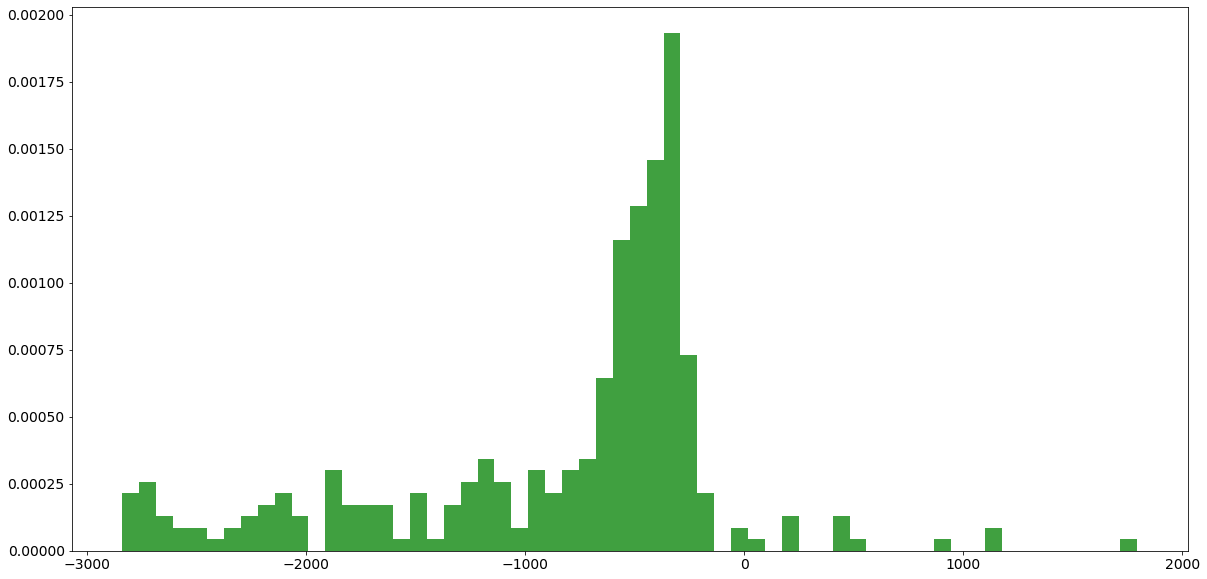

In [ ]:
test=profit_gamma_call(strike1,exp1,value1,payoff1,delta1,gamma1,
                       strike2,exp2,value2,payoff2,delta2,gamma2,
                       predicted,num_predictions,7,r_2017,sigma)

test = test[abs(test) < 3000]
print( np.mean(test), np.std(test) )

plt.figure(figsize=(20,10))
# The histogram of the data
n, bins, patches = plt.hist(test, 60, facecolor='green', alpha=0.75, density=True)

-816.7160328616204 1020.168728311515


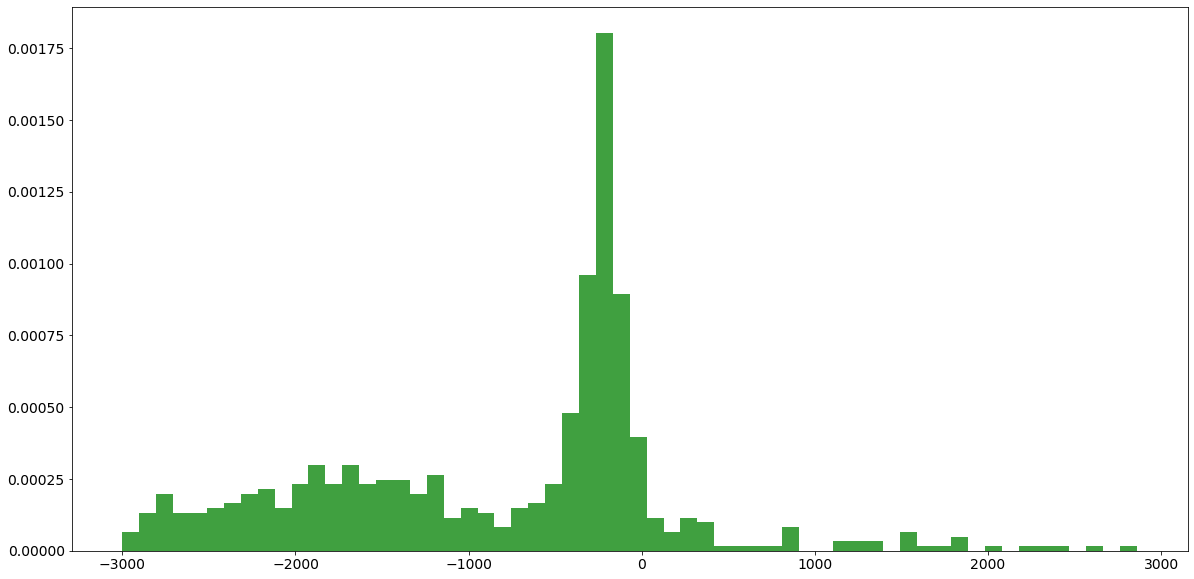

In [ ]:
test=profit_gamma_call(strike1,exp1,value1,payoff1,delta1,gamma1,
                       strike2,exp2,value2,payoff2,delta2,gamma2,
                       predicted,num_predictions,30,r_2017,sigma)

test = test[abs(test) < 3000]
print( np.mean(test), np.std(test) )

plt.figure(figsize=(20,10))
# The histogram of the data
n, bins, patches = plt.hist(test, 60, facecolor='green', alpha=0.75, density=True)

In [ ]:
def cost(x,s_old,low_old,eq_old,hi_old, s,vl,ve,vh):
  return abs(x[0]-s_old)*s + abs(x[1]-low_old)*vl + abs(x[2]-eq_old)*ve + abs(x[3]-hi_old)*vh

def optimal_3(D,dl,de,dh, G,gl,ge,gh, s_old,low_old,eq_old,hi_old, s,vl,ve,vh):
  if G<0:
    cons=optimize.LinearConstraint([[1,dl,de,dh],[0,gl,ge,gh]],lb=[D*0.99,G*1.01],ub=[D*1.01,G*0.99])
  else:
    cons=optimize.LinearConstraint([[1,dl,de,dh],[0,gl,ge,gh]],lb=[D*0.99,G*0.99],ub=[D*1.01,G*1.01])
  #cons=optimize.LinearConstraint([[1,dl,de,dh],[0,gl,ge,gh]],lb=[D*0.99,B*0.99],ub=[D*1.01,B*1.01])

  x0=np.array([0.5,low_old+1,eq_old+1,hi_old+1])
  bound=optimize.Bounds([0,0,0,0],[10,1000,1000,1000])
  res=optimize.minimize(cost, x0, args=(s_old,low_old,eq_old,hi_old, s,vl,ve,vh), constraints=cons,bounds=bound)
  return res.x

In [ ]:
def profit_multi_gamma_call(strike1,    value1, payoff1, delta1, gamma1, exp_date_1,
                            strike_dif, value2, payoff2, delta2, gamma2, expire_dif,
                            trajectories,num,frequency,r,si):
  """ 
  Zakładamy że portfel ma na początku wartość 0. Obliczamy nasz zysk po roku z opcji zabezpieczanej indeksem.
  Zabezpieczamy trzema opcjami: jedną na cenę równą obecnej, jedną o striku wyższym i jedną o niższym
  Posiadamy a indeksu, b1 opcji o niższym striku, b2 o równym cenie z dnia kupna opcji, b3 o wyższym

  Istotne parametry to expdif (ustalone na 12 oznacza że nie zmieniamy serii opcji którą operujemy) oraz frequency
  
  Parametry:
    strike1, exp_date_1 - cena strike i data wygaśnięcia  opcji głównej
    strike_dif - różnica między cenami opcji zabezpieczających
    expire_dif - liczba miesięcy między kolejnymi kupowanymi seriami opcji
    value1, payoff1, delta1, gamma1 - odpowiednie funkcje dla opcji głównej
    value2, payoff2, delta2, gamma2 - odpowiednie funkcje dla opcji zabezpieczających
    trajectories -  zbiór trajektorii kursu indeksu. Tabela wymiarów (num, trading_days_2017)
    num -           liczba rozważanych trajektorii, j.w.
    frequency -     co ile dni giełdowych aktualizujemy portfel
    r -             stopa procentowa nie obciążona ryzykiem
    si -            sigma, zmienność rozważanego indeksu
  Return:
    cash -          tablica długości num, zawierająca wartość portfela dnia wygaśnięcia po zamknięciu wszystkich pozycji
  """
    # Ustalamy datę startu na 01.01. oraz tablicę dni handlowych w 2017
  daty_2017=wig_20_daily_2017['Date'].to_numpy()
  start_date=pd.to_datetime('2017-01-01')

  # Opcja wygasa w trzeci piatek grudnia
  exp_date_2017 = pd.to_datetime(['2017-01-20','2017-02-17','2017-03-17','2017-04-21','2017-05-19','2017-06-16','2017-07-21','2017-08-18','2017-09-15','2017-10-20','2017-11-17','2017-12-15'])
  expire_index_local = np.full(12,0)
  for i in range(0,12):
    expire_index_local[i] = np.where(daty_2017 == pd.to_datetime(exp_date_2017[i]))[0][0]
  
  expire_date1 = pd.to_datetime(exp_date_1)
  expire_index1 = np.where(daty_2017 == expire_date1)[0][0]  # index dnia 15.12.2017
  
  # Strike opcji pomocniczych i moment wygaśnięcia
  sl = np.full(num,trajectories[0][0]-strike_dif)
  se = np.full(num,trajectories[0][0])
  sh = np.full(num,trajectories[0][0]+strike_dif)

  # Którą serią opcji pomocniczych operujemy
  mult = 1
  next_expire = expire_index_local[expire_dif*mult-1]  

  # parametry a,b na początku są we wszystkich portfelach takie same
  G = gamma1(trajectories[0][0], strike1, 0, expire_index1, si, r)
  gl = gamma2(trajectories[0][0], sl[0], 0, next_expire, si, r)
  ge = gamma2(trajectories[0][0], se[0], 0, next_expire, si, r)
  gh = gamma2(trajectories[0][0], sh[0], 0, next_expire, si, r)

  D = delta1(trajectories[0][0], strike1, 0, expire_index1, si, r)
  dl = delta2(trajectories[0][0], sl[0], 0, next_expire, si, r)
  de = delta2(trajectories[0][0], se[0], 0, next_expire, si, r)
  dh = delta2(trajectories[0][0], sh[0], 0, next_expire, si, r)
  
  V = value1(trajectories[0][0],strike1,0,expire_index1,si,r)
  vl = value2(trajectories[0][0],sl[0],0,next_expire,si,r)
  ve = value2(trajectories[0][0],se[0],0,next_expire,si,r)
  vh = value2(trajectories[0][0],sh[0],0,next_expire,si,r)

  # Ilości kupionych aktywów
  amount = optimal_3(D,dl,de,dh, G,gl,ge,gh, 0,0,0,0, trajectories[0][0],vl,ve,vh)
  a = np.full(num,amount[0])
  b1 = np.full(num,amount[1])
  b2 = np.full(num,amount[2])
  b3 = np.full(num,amount[3])
  # Początkowy cash też nie zależy od wyboru trajektorii, bo cena opcji od niej nie zależy
  # Sprzedajemy opcję, więc mamy z niej dodatnie pieniądze. W takim razie potrzebujemy kupić delta sztuk indeksu (na odwrót niż w standardowo opisywanym modelu)
  transaction = V - a[0]*trajectories[0][0] - b1[0]*vl - b2[0]*ve - b3[0]*vh
  cash=np.full(num, transaction - 0.04* abs( V ) - 0.04 * abs(a[0]*trajectories[0][0]) - 0.04*abs(b1[0])*vl - 0.04*abs(b2[0])*ve - 0.04*abs(b3[0])*vh)
  last=0
  for i in range(1,expire_index1):
    # Doszliśmy do wygaśnięcia opcji pomocniczych, są one wykonywane i ustalamy ceny nowych
    if i==next_expire:
      for j in range(0,num):
        S = trajectories[j][i]
        if last == 0:
          time = i % frequency
          if time == 0:
            time = frequency
        if last>0:
          time = i-last
        cash[j]=cash[j]*math.exp(r*time/trading_days_2017) + b1[j]*payoff2(S,sl[j]) + b2[j]*payoff2(S,se[j]) + b3[j]*payoff2(S,sh[j])
        b1[j]=0
        b2[j]=0
        b3[j]=0
        se[j]=S
        sl[j]=se[j]-strike_dif
        sh[j]=se[j]+strike_dif
      last=i
      mult=mult+1
      time=i
    # Rehedging wynikający albo z normalnej częstotliwości albo z wygaśnięcia opcji
    if i % frequency==0 or i==next_expire:
      if i % frequency==0:
        time=frequency
        last=0
      if i==next_expire:
        if expire_dif*mult-1<11:
          next_expire=expire_index_local[expire_dif*mult-1]
        else:
          next_expire=expire_index_local[11]
      for j in range(0,num):
        # Nowe delta/gamma/a/b
        G = gamma1(trajectories[j][i], strike1, i, expire_index1, si, r)
        gl = gamma2(trajectories[j][i], sl[j], i, next_expire, si, r)
        ge = gamma2(trajectories[j][i], se[j], i, next_expire, si, r)
        gh = gamma2(trajectories[j][i], sh[j], i, next_expire, si, r)

        D = delta1(trajectories[j][i], strike1, i, expire_index1, si, r)
        dl = delta2(trajectories[j][i], sl[j], i, next_expire, si, r)
        de = delta2(trajectories[j][i], se[j], i, next_expire, si, r)
        dh = delta2(trajectories[j][i], sh[j], i, next_expire, si, r)

        V=value1(trajectories[j][i],strike1,i,expire_index1,si,r)
        vl=value2(trajectories[j][i],sl[j], i,next_expire,si,r)
        ve=value2(trajectories[j][i],se[j], i,next_expire,si,r)
        vh=value2(trajectories[j][i],sh[j], i,next_expire,si,r)

        amount=optimal_3(D,dl,de,dh, G,gl,ge,gh, a[j],b1[j],b2[j],b3[j], trajectories[j][i],vl,ve,vh)
        a_new=amount[0]
        b1_new=amount[1]
        b2_new=amount[2]
        b3_new=amount[3]
        # Skapitalizowane posiadane pieniądze pomniejszone o cenę sprzedanego indeksu w ilości d-delta[j]
        # frequency jest w dniach giełdowych, więc normalizujemy przez 250.
        
        # wartość transakcji: ilość kupowanych akcji/opcji razy ich wartość w danej chwili
        transaction_value = (a_new-a[j])*trajectories[j][i] + (b1_new - b1[j])*vl + (b2_new-b2[j])*ve + (b3_new-b3[j])*vh
        # koszt transakcji: płacimy niezależnie od tego czy kupujemy czy sprzedajemy
        transaction_cost = 0.04*abs(a_new-a[j])*trajectories[j][i] + 0.04*abs(b1_new - b1[j])*vl + 0.04*abs(b2_new-b2[j])*ve + 0.04*abs(b3_new-b3[j])*vh
        
        cash[j] = cash[j]*math.exp(r*time/trading_days_2017) - (transaction_value + transaction_cost)
        b1[j] = b1_new
        b2[j] = b2_new
        b3[j] = b3_new
        a[j] = a_new
  # Ile dni przed zapadnięciem odbył się ostatni rehedging.
  # last=0 oznacza że ostatni wynikał z frequency, last>0 że był wynikiem wygaśnięcia poprzedniej opcji
  if last==0:
    rest=expire_index1 % frequency
  else:
    rest=expire_index1-last
  # Spieniężamy portfel
  for j in range(0,num):
    index_value = trajectories[j][expire_index1]
    payoff= payoff1(index_value, strike1) 
    transaction_cost = abs(a[j])*index_value * 0.04
    cash[j]=cash[j]*math.exp(r*rest/trading_days_2017) + a[j]*index_value + b1[j]*payoff2(index_value, sl[j]) + b2[j]*payoff2(index_value, se[j]) + b3[j]*payoff2(index_value, sh[j])- payoff - transaction_cost
  return cash


strike1 = 2000
exp1 = '2017-12-15'
value1 = vcall
payoff1 = call_payoff
delta1 = delta_call
gamma1 = gamma_call

strikedif = 100
expdif = 12
value2 = vbinarycall
payoff2 = binarycall_payoff
delta2 = delta_binarycall
gamma2 = gamma_binarycall

In [ ]:
r_2017=0.02
test=profit_multi_gamma_call(strike1,value1,payoff1,delta1,gamma1,exp1,
                             strikedif,value2,payoff2,delta2,gamma2,expdif,
                             predicted,num_predictions,50,r_2017,sigma)

#test = test[abs(test) < 3000]
print( np.mean(test), np.std(test) )

plt.figure(figsize=(20,10))
n, bins, patches = plt.hist(test, 60, facecolor='green', alpha=0.75, density=True)

plt.title('Histogram zysku z portfelu hedgowanego trzema pomocniczymi opcjami')
plt.xlabel('Zysk')
#plt.ylabel('Pstwo')
